In [1]:
import pandas as pd
from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness
import aequitas.plot as ap

In [2]:
import os
from pathlib import Path
import sys
CWD = os.getcwd()
curr_file_path = Path(CWD)
sys.path.append(str(curr_file_path.parent))

In [3]:
from ml.preprocess_data import process_data
from ml.train_model import split_data,get_cat_features
from ml.model_func import training_model, compute_model_metrics, inference


In [5]:
import joblib
from sklearn.model_selection import train_test_split
DATA_PATH =  os.path.join(curr_file_path.parent,"data/census_cleaned.csv")
MODEL_PATH = os.path.join(curr_file_path.parent,"models/rfc_model.pkl")
ENCODER_PATH = os.path.join(curr_file_path.parent,"models/encoder.pkl")
LB_PATH = os.path.join(curr_file_path.parent, "models/lb.pkl")
cleaned_data = pd.read_csv(DATA_PATH)
train, test = split_data(cleaned_data)
model = joblib.load(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)
lb = joblib.load(LB_PATH)
X_test_proc, y_test_proc, _, _ = process_data(
        test, categorical_features=get_cat_features(), label='salary', training=False, encoder=encoder, lb=lb
    )
pred = model.predict(X_test_proc)

In [32]:
df_aq = test.reset_index(drop=True).copy()
from aequitas.preprocessing import preprocess_input_df
df_aq, _ = preprocess_input_df(df_aq)
# Construct the dataframe that Aequitas will use.
df_aq['label_value'] = y_test_proc
df_aq['score'] = pred
df_aq, _ = preprocess_input_df(df_aq)
df_aq.drop('salary',axis=1,inplace=True)
df_aq.head()


2022-01-27 18:18:31,707 preprocessing.preprocess_input_df: input dataframe does not have all the required columns.


,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label_value,score
0,17.00-27.00,Private,179692.50-240152.50,HS-grad,1.00-9.00,Never-married,Sales,Own-child,White,Female,0.00-99999.00,0.00-3900.00,1.00-40.00,United-States,0,0
1,37.00-48.00,State-gov,19847.00-118844.00,Doctorate,13.00-16.00,Never-married,Exec-managerial,Not-in-family,White,Female,0.00-99999.00,0.00-3900.00,1.00-40.00,Italy,1,0
2,17.00-27.00,Private,19847.00-118844.00,Some-college,9.00-10.00,Married-civ-spouse,Craft-repair,Husband,White,Male,0.00-99999.00,0.00-3900.00,45.00-99.00,United-States,0,0
3,27.00-37.00,Private,118844.00-179692.50,Some-college,9.00-10.00,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.00-99999.00,0.00-3900.00,1.00-40.00,United-States,0,0
4,37.00-48.00,Private,118844.00-179692.50,Bachelors,10.00-13.00,Married-civ-spouse,Adm-clerical,Husband,White,Male,0.00-99999.00,0.00-3900.00,1.00-40.00,United-States,1,1


In [33]:
# Run Aequitas.
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
xtab.head()

2022-01-27 18:18:39,834 getcrosstabs: attribute columns to perform crosstabs:age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,1125,age,17.00-27.00,0.380000,0.997473,0.019255,0.173913,0.002527,...,0.014085,4,31,1579,19,50,1583,1633,6508,0.030618
1,0,binary 0/1,1125,age,27.00-37.00,0.549505,0.949425,0.128079,0.229167,0.050575,...,0.168520,66,182,1239,222,404,1305,1709,6508,0.236396
2,0,binary 0/1,1125,age,37.00-48.00,0.594937,0.929142,0.215670,0.158837,0.070858,...,0.273562,71,256,931,376,632,1002,1634,6508,0.386781
3,0,binary 0/1,1125,age,48.00-90.00,0.579044,0.947368,0.196567,0.141689,0.052632,...,0.239556,52,229,936,315,544,988,1532,6508,0.355091
4,0,binary 0/1,1125,workclass,?,0.571429,0.987055,0.046875,0.166667,0.012945,...,0.069767,4,15,305,20,35,309,344,6508,0.101744


In [34]:
bias = Bias()
bias_df = bias.get_disparity_major_group(xtab, original_df=df_aq, alpha=0.05, mask_significance=True)
bias_df.head()

get_disparity_major_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,1125,age,17.00-27.00,0.380000,0.997473,0.019255,0.173913,0.002527,...,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00
1,0,binary 0/1,1125,age,27.00-37.00,0.549505,0.949425,0.128079,0.229167,0.050575,...,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00
2,0,binary 0/1,1125,age,37.00-48.00,0.594937,0.929142,0.215670,0.158837,0.070858,...,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00
3,0,binary 0/1,1125,age,48.00-90.00,0.579044,0.947368,0.196567,0.141689,0.052632,...,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00,27.00-37.00
4,0,binary 0/1,1125,workclass,?,0.571429,0.987055,0.046875,0.166667,0.012945,...,Private,Private,Private,Private,Private,Private,Private,Private,Private,Private


In [35]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)
fairness_df.head()

2022-01-27 18:18:46,169 get_group_value_fairness...


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,1125,age,17.00-27.00,0.380000,0.997473,0.019255,0.173913,0.002527,...,False,False,True,True,True,False,False,False,False,False
1,0,binary 0/1,1125,age,27.00-37.00,0.549505,0.949425,0.128079,0.229167,0.050575,...,True,True,True,True,True,True,True,True,True,True
2,0,binary 0/1,1125,age,37.00-48.00,0.594937,0.929142,0.215670,0.158837,0.070858,...,True,True,True,True,True,False,False,False,False,False
3,0,binary 0/1,1125,age,48.00-90.00,0.579044,0.947368,0.196567,0.141689,0.052632,...,True,True,True,True,True,False,False,True,False,False
4,0,binary 0/1,1125,workclass,?,0.571429,0.987055,0.046875,0.166667,0.012945,...,True,True,True,True,True,False,False,False,False,False


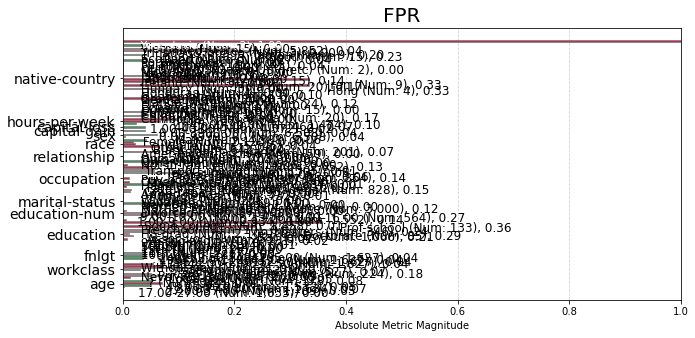

In [36]:
from aequitas.plotting import Plot

aqp = Plot()
fpr_fairness = aqp.plot_fairness_group(fairness_df, group_metric='fpr', title=True)

In [37]:
overall_fairness = fairness.get_overall_fairness(fairness_df)
print(overall_fairness)

{'Unsupervised Fairness': False, 'Supervised Fairness': False, 'Overall Fairness': False}


In [38]:
metrics = ['fpr', "for", "fnr"]
disparity_metrics = [f"{metric}_disparity" for metric in metrics]

In [39]:
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics]

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,age,17.00-27.00,0.002527,0.019255,0.620000,0.049963,0.150334,1.376264
1,age,27.00-37.00,0.050575,0.128079,0.450495,1.000000,1.000000,1.000000
2,age,37.00-48.00,0.070858,0.215670,0.405063,1.401062,1.683883,0.899151
3,age,48.00-90.00,0.052632,0.196567,0.420956,1.040670,1.534731,0.934430
4,workclass,?,0.012945,0.046875,0.428571,0.407305,0.379385,0.933769
...,...,...,...,...,...,...,...,...
112,native-country,Taiwan,0.200000,0.200000,0.250000,5.073256,1.513793,0.583464
113,native-country,Trinadad&Tobago,0.000000,0.000000,NaN,0.000000,0.000000,NaN
114,native-country,United-States,0.039422,0.132118,0.428475,1.000000,1.000000,1.000000
115,native-country,Vietnam,0.000000,0.000000,NaN,0.000000,0.000000,NaN


In [40]:
eps = 0.000001
bias_df[disparity_metrics] = bias_df[disparity_metrics].fillna(0.0) + eps
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics]

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,age,17.00-27.00,0.002527,0.019255,0.620000,0.049964,0.150335,1.376265
1,age,27.00-37.00,0.050575,0.128079,0.450495,1.000001,1.000001,1.000001
2,age,37.00-48.00,0.070858,0.215670,0.405063,1.401063,1.683884,0.899152
3,age,48.00-90.00,0.052632,0.196567,0.420956,1.040671,1.534732,0.934431
4,workclass,?,0.012945,0.046875,0.428571,0.407306,0.379386,0.933770
...,...,...,...,...,...,...,...,...
112,native-country,Taiwan,0.200000,0.200000,0.250000,5.073257,1.513794,0.583465
113,native-country,Trinadad&Tobago,0.000000,0.000000,NaN,0.000001,0.000001,0.000001
114,native-country,United-States,0.039422,0.132118,0.428475,1.000001,1.000001,1.000001
115,native-country,Vietnam,0.000000,0.000000,NaN,0.000001,0.000001,0.000001


In [43]:
(bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics]).to_csv('bias_df.csv',index=False)